In [1]:
%matplotlib inline
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import os
import time
import datetime
import warnings
import matplotlib
matplotlib.rcParams.update({'font.size': 16})
import pandas
import numpy
import scipy.stats
import abcutils

## Load and Synthesize Data from CSV

This process loads each summary CSV file, creates a few derived metrics, and then merges each system's CSV into a single global dataset that can be sliced and diced by system, benchmark, or any other way.  We are now caching the processed CSV in HDF5 format to speed up initial data ingest at the beginning of each analysis.  Delete the `CACHE_FILE` to re-generate this cache (e.g., when the contents of the CSV are updated).

In [4]:
filtered_df = abcutils.sc18paper.load_dataset()

Loading from cache cache.hdf5
Start with 14536 rows before filtering
Dropped 42 rows after filter #0 (14494 left)
Dropped 14 rows after filter #1 (14480 left)
Dropped 38 rows after filter #2 (14442 left)
Dropped 5 rows after filter #3 (14437 left)
Dropped 2451 rows after filter #4 (11986 left)
11986 rows remaining


## Demonstrate a Single Test Platform

Look at one combination of (compute system, file system, benchmark) to show what this UMAMI analysis can do.

### Define Input Parameters

In [5]:
TEST_PLATFORM = 'scratch2@edison'
# TEST_PLATFORM = 'cscratch@cori-knl'
# TEST_PLATFORM = 'cscratch@cori-haswell'
# TEST_PLATFORM = 'mira-fs1@mira'

BENCHMARK_ID = 'ior_fpp_write'
# BENCHMARK_ID = 'ior_fpp_read'
# BENCHMARK_ID = 'dbscan_read_shared_read'
# BENCHMARK_ID = 'vpicio_uni_shared_write'
# BENCHMARK_ID = 'ior_shared_write'
# BENCHMARK_ID = 'ior_shared_read'
# BENCHMARK_ID = 'hacc_io_read_fpp_read'
# BENCHMARK_ID = 'hacc_io_write_fpp_write'

plot_metric = 'darshan_normalized_perf_by_max'
delta = datetime.timedelta(days=1).total_seconds()

example_df = filtered_df.groupby(by=['_test_platform', '_benchmark_id']).get_group((TEST_PLATFORM, BENCHMARK_ID)).copy()
example_df = filtered_df.groupby(by=['_test_platform']).get_group((TEST_PLATFORM)).copy()

print "test_platform =", TEST_PLATFORM
print "benchmark_id =", abcutils.CONFIG['benchmark_labels'].get(BENCHMARK_ID, BENCHMARK_ID)
print "plot_metric =", abcutils.CONFIG['metric_labels'].get(plot_metric, plot_metric)
print "date_start =", abcutils.sc18paper.DATE_START.isoformat()
print "date_end =", abcutils.sc18paper.DATE_END.isoformat()

test_platform = scratch2@edison
benchmark_id = IOR file-per-process write
plot_metric = Fraction Peak Perf
date_start = 2017-02-14T00:00:00
date_end = 2018-02-15T00:00:00


In [6]:
# Metrics to include in UMAMI renderings and analysis.  Anything that
# _might_ affect performance should be included here.
umami_rows = [
    'darshan_normalized_perf_by_max',
    'coverage_factor_bw',
#   'coverage_factor_nodehrs',
    'coverage_factor_opens',
    'coverage_factor_stats',
    'coverage_factor_ops',
    'fs_ave_mds_cpu',
#   'fs_tot_metadata_ops',
    'fs_ave_oss_cpu',
#   'fs_tot_open_ops',
    'fshealth_ost_most_full_pct',
    'fshealth_ost_overloaded_oss_count',
#   'jobsdb_concurrent_nodes',
    'topology_job_max_radius',
]

## Region-defined Correlation

In [7]:
# Width of simple moving average (SMA) short/long windows
SHORT_WINDOW = pandas.Timedelta(days=14)
LONG_WINDOW = pandas.Timedelta(days=48)

print "Short window will average over %s at a time" % SHORT_WINDOW
print "Long window will average over %s at a time" % LONG_WINDOW

Short window will average over 14 days 00:00:00 at a time
Long window will average over 48 days 00:00:00 at a time


## Calculate intercepts and centroids from SMAs

* **Intercepts** are the place where two SMAs cross each other
* **Performance regions** are the data bounded by two intercepts
* **Centroids** are the centermost data point in a performance region

With this nomenclature, it is possible to also define **centroid regions** which are bounded by two centroids.  These regions capture the transition between two performance regions.

In [8]:
sma_short = abcutils.features.calculate_sma(example_df,
                                            '_datetime_start',
                                            plot_metric,
                                            window=SHORT_WINDOW)
sma_long = abcutils.features.calculate_sma(example_df,
                                           '_datetime_start',
                                           plot_metric,
                                           window=LONG_WINDOW)

In [9]:
sma_intercepts = abcutils.features.find_sma_intercepts(sma_short,
                                                        sma_long,
                                                        example_df['_datetime_start'])
sma_intercepts

,_datetime_start,positive,sma_long,sma_short
index,,,,
2835,2017-02-27 17:46:42,False,0.695993,0.693021
2972,2017-03-09 17:58:49,True,0.697353,0.697808
3207,2017-03-29 19:08:51,False,0.661351,0.660389
1869,2017-03-29 19:10:10,True,0.661351,0.662272
958,2017-03-29 19:11:51,False,0.661351,0.653672
3358,2017-04-16 19:11:40,True,0.673221,0.695399
3557,2017-05-03 20:37:34,False,0.710634,0.698382
3605,2017-05-07 20:16:22,True,0.712974,0.718890
3713,2017-05-16 18:45:50,False,0.711505,0.711050


In [22]:
abcutils.features.find_sma_centroids(example_df,
                                     sma_short,
                                     sma_long,
                                     sma_intercepts,
                                     x_column='_datetime_start',
                                     min_width=None)

,_datetime_start,positive,sma_long,sma_short
index,,,,
2908,2017-03-04 17:45:40,True,0.638763,0.691164
3084,2017-03-19 18:59:10,False,0.631204,0.576987
3264,2017-04-07 18:54:08,True,0.615297,0.523700
3451,2017-04-25 03:40:24,False,0.660966,0.556738
221,2017-05-04 20:43:31,True,0.696512,0.715449
242,2017-05-11 19:09:37,False,0.697404,0.717096
253,2017-05-15 18:59:25,True,0.697212,0.723185
3749,2017-05-19 18:59:51,True,0.682917,0.738019
3776,2017-05-21 19:03:32,False,0.681215,0.736671


In [23]:
sma_centroids = abcutils.features.sma_centroids(example_df,
                                                plot_metric,
                                                short_window=SHORT_WINDOW,
                                                long_window=LONG_WINDOW,
                                                min_width=None)
sma_centroids

,_datetime_start,positive,sma_long,sma_short
index,,,,
2908,2017-03-04 17:45:40,True,0.638763,0.691164
3084,2017-03-19 18:59:10,False,0.631204,0.576987
3264,2017-04-07 18:54:08,True,0.615297,0.523700
3451,2017-04-25 03:40:24,False,0.660966,0.556738
221,2017-05-04 20:43:31,True,0.696512,0.715449
242,2017-05-11 19:09:37,False,0.697404,0.717096
253,2017-05-15 18:59:25,True,0.697212,0.723185
3749,2017-05-19 18:59:51,True,0.682917,0.738019
3776,2017-05-21 19:03:32,False,0.681215,0.736671


### Visualize intercepts and centroids
Plot the SMAs, performance regions, and centroids as a visual sanity check.


Plot the following:
(1) raw data (blue bars)
(2) sma_short (thick line #1)
(3) sma_long (thick line #2)
(4) intercept regions (shaded grey boxes)
(5) centroid boundaries (black lines) -- these should bisect grey boxes



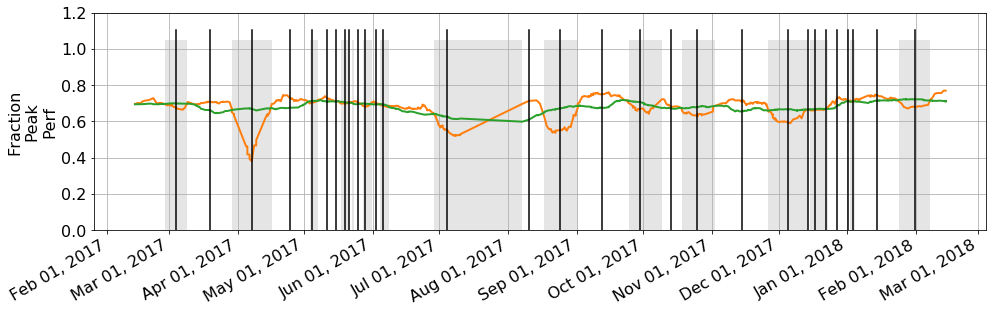

In [24]:
print """
Plot the following:
(1) raw data (blue bars)
(2) sma_short (thick line #1)
(3) sma_long (thick line #2)
(4) intercept regions (shaded grey boxes)
(5) centroid boundaries (black lines) -- these should bisect grey boxes
"""
ax = abcutils.plot.sma_overlaps(dataframe=example_df,
                                plot_metric=plot_metric,
                                short_window=SHORT_WINDOW,
                                long_window=LONG_WINDOW,
                                sma_intercepts=sma_intercepts,
                                method='value')

xmin, xmax = ax.get_xlim()
ax.set_xlim(xmin, xmax)

ymin, ymax = ax.get_ylim()
for x in sma_centroids['_datetime_start']:
    ax.plot([abcutils.core.pd2epoch(x), abcutils.core.pd2epoch(x)], [ymin, ymax], color='black')

abcutils.plot.fix_xticks_timeseries(ax)

### Filter centroids

We only care about centroids that show a significant swing in performance.

Now we plot the centroid-defined regions


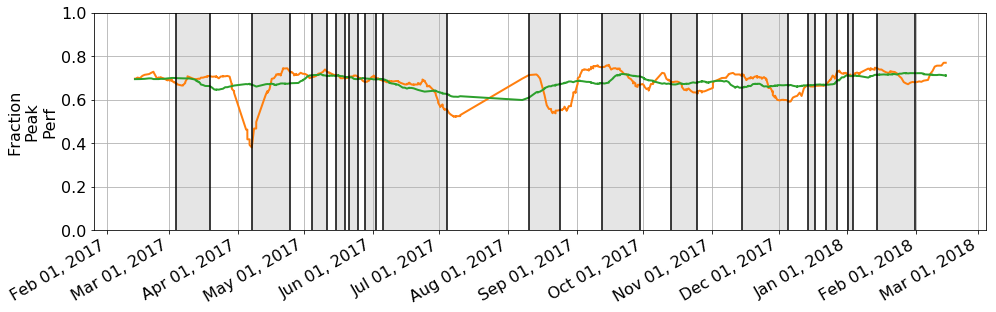

In [25]:
ax = abcutils.plot.sma_overlaps(dataframe=example_df,
                                plot_metric=plot_metric,
                                short_window=SHORT_WINDOW,
                                long_window=LONG_WINDOW,
                                sma_intercepts=sma_centroids,
                                method='value')
xmin, xmax = ax.get_xlim()
ax.set_xlim(xmin, xmax)
ymin, ymax = ax.set_ylim(0, 1)
for x in sma_centroids['_datetime_start']:
    ax.plot([abcutils.core.pd2epoch(x), abcutils.core.pd2epoch(x)], [ymin, ymax], color='black')
    
abcutils.plot.fix_xticks_timeseries(ax)
print "Now we plot the centroid-defined regions"

In [14]:
print """
Apply a magnitude-of-change filter to the centroid regions and only
keep regions that show a significant difference between their first
and last values of sma_short.

Also plot the start/end values that are being used to determine the
cutoff.  If they do not visually line up on the sma_short plot, the
centroid identification algorithms are not correct.
"""
cutoff = 0.10

regions = list(abcutils.features.intercepts_to_region(example_df, sma_centroids))

print "All centroid regions:"
centroid_regions = []
for index, region in enumerate(regions):
    if len(region) == 0:
        continue
    # index+1 should always be valid for sma_centroids since regions[0] has one fewer region than boundaries
    this_value = sma_centroids.iloc[index]['sma_short']
    next_value = sma_centroids.iloc[index+1]['sma_short']
    centroid_delta = next_value - this_value
    centroid_delta /= next_value
    
    # Plot the centroid start/end points to visually confirm correctness
    if abs(centroid_delta) >= cutoff:
        centroid_regions.append(region)
        ax.plot(abcutils.core.pd2epoch(sma_centroids.iloc[index]['_datetime_start']), this_value, marker='o', color='red')
        ax.plot(abcutils.core.pd2epoch(sma_centroids.iloc[index+1]['_datetime_start']), next_value, marker='8', color='red')
    print "%s: %5s %7.4f %8.3f %5.3f" % (
        region.iloc[0]['_datetime_start'],
        abs(centroid_delta) >= cutoff,
        centroid_delta,
        this_value,
        next_value)

print "\nFlagged regions:"
if not centroid_regions:
    print "  (none)"
else:
    for region in centroid_regions:
        print region.iloc[0]['_datetime_start'], 'to', region.iloc[-1]['_datetime_start']


Apply a magnitude-of-change filter to the centroid regions and only
keep regions that show a significant difference between their first
and last values of sma_short.

Also plot the start/end values that are being used to determine the
cutoff.  If they do not visually line up on the sma_short plot, the
centroid identification algorithms are not correct.

All centroid regions:
2017-03-04 17:45:40:  True -0.1979    0.691 0.577
2017-03-19 18:59:10:  True -0.1018    0.577 0.524
2017-04-07 18:54:08: False  0.0593    0.524 0.557
2017-05-04 20:43:31: False  0.0023    0.715 0.717
2017-05-11 19:09:37: False  0.0084    0.717 0.723
2017-05-15 18:59:25: False  0.0201    0.723 0.738

Flagged regions:
2017-03-04 17:45:40 to 2017-03-18 18:49:44
2017-03-19 18:59:10 to 2017-04-06 19:08:08


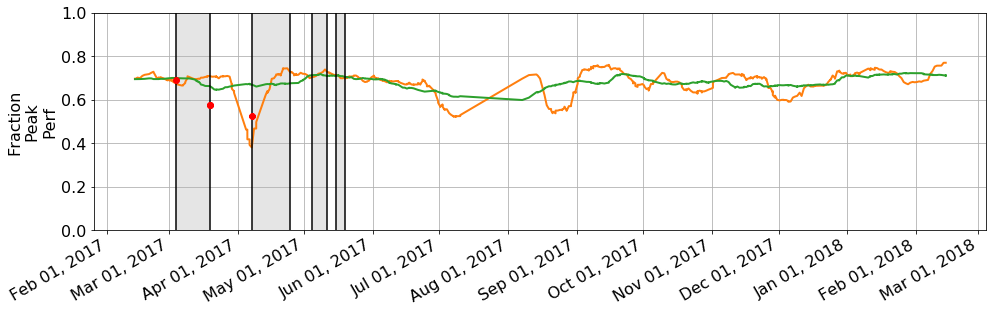

In [15]:
ax.get_figure()

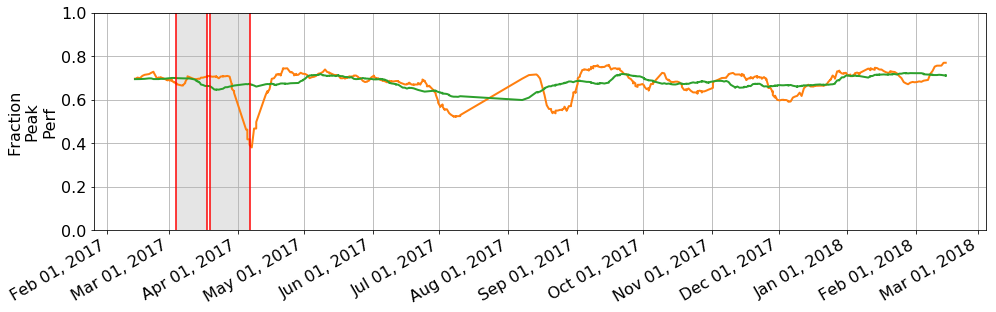

In [16]:
ax = abcutils.plot.sma_overlaps(dataframe=example_df,
                                plot_metric=plot_metric,
                                short_window=SHORT_WINDOW,
                                long_window=LONG_WINDOW,
                                sma_intercepts=sma_intercepts[0:1],
                                method='value')

## Plot regions
min_y, max_y = ax.set_ylim(0, 1)
regions_shown = 0
for region in centroid_regions:
    min_x = abcutils.core.pd2epoch(region.iloc[0]['_datetime_start'])
    max_x = abcutils.core.pd2epoch(region.iloc[-1]['_datetime_start'])
    ax.add_patch(matplotlib.patches.Rectangle(xy=(min_x, min_y),
                 width=(max_x - min_x),
                 height=(max_y - min_y),
                 facecolor='black',
                 linewidth=0,
                 alpha=0.10,
                 zorder=0))
    ax.plot([min_x, min_x], [min_y, max_y], color='red')
    ax.plot([max_x, max_x], [min_y, max_y], color='red')

abcutils.plot.fix_xticks_timeseries(ax)

In [17]:
pcutoff = 1.0e-5
results = {
    'region_start': [],
    'region_end': [],
    'region_start_index': [],
    'region_end_index': [],
    'metric': [],
    'coeff': [],
    'pvalue': [],
    'region_points': []
}
identified_regions = []

for region in centroid_regions:
    x = region[plot_metric].values
    base_nan_filter = numpy.isnan(x)
    title = "%s - %s (%d points)" % (
        region.iloc[0]['_datetime_start'],
        region.iloc[-1]['_datetime_start'],
        len(x[~base_nan_filter])
    )
    print "new region:", title
    identified = False
    for y_label in umami_rows: #example_df.columns: #umami_rows:
        if y_label == plot_metric:
            continue
        y = example_df.loc[region.index][y_label].values
        try:
            nan_filter = base_nan_filter | numpy.isnan(y)
        except TypeError:
            # non-numeric; pass
            continue
        this_x = x[~nan_filter]
        this_y = y[~nan_filter]
        if len(this_y) > 0:
            coeff, pval = scipy.stats.pearsonr(this_x, this_y)
            if pval < pcutoff and coeff < 0.9999:
                results['region_start'].append(region.iloc[0]['_datetime_start'])
                results['region_end'].append(region.iloc[-1]['_datetime_start'])
                results['region_start_index'].append(region.index[0])
                results['region_end_index'].append(region.index[-1])
                results['metric'].append(y_label)
                results['coeff'].append(coeff)
                results['pvalue'].append(pval)
                results['region_points'].append(len(x[~base_nan_filter]))
                fig, ax = matplotlib.pyplot.subplots()
                ax.scatter(this_x, this_y)
                ax.set_xlabel(abcutils.CONFIG['metric_labels'].get(plot_metric, plot_metric))
                ax.set_ylabel(abcutils.CONFIG['metric_labels'].get(y_label, y_label).replace(' (', '\n('))
                ax.grid()
                fit = scipy.stats.linregress(this_x, this_y)
                ax.set_xlim(ax.get_xlim())
                ax.plot(ax.get_xticks(),
                        [fit.slope * xi + fit.intercept for xi in ax.get_xticks()],
                        color='C2',
                       linewidth=3)
                print "    Fit for", y_label, title
                print "    Coefficient: %12.4f" % coeff
                print "    p-value:     %12.4e" % pval
                print "    Slope:       %12.4f" % fit.slope
                print "    Rval:        %12.4e" % fit.rvalue
                print
                identified = True

    # Keep track of regions that have known root causes
    if identified:
        identified_regions.append(region)
    print

results_df = pandas.DataFrame.from_dict(results)
results_df

new region: 2017-03-04 17:45:40 - 2017-03-18 18:49:44 (60 points)

new region: 2017-03-19 18:59:10 - 2017-04-06 19:08:08 (60 points)



/opt/anaconda2/lib/python2.7/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


,coeff,metric,pvalue,region_end,region_end_index,region_points,region_start,region_start_index


## Plot identified region(s)

TypeError: unsupported operand type(s) for -: 'NoneType' and 'NoneType'

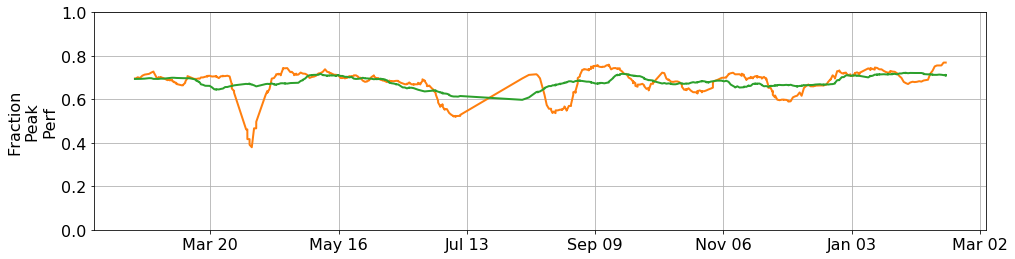

In [18]:
ax = abcutils.plot.sma_overlaps(dataframe=example_df,
                                plot_metric=plot_metric,
                                short_window=SHORT_WINDOW,
                                long_window=LONG_WINDOW,
                                sma_intercepts=sma_intercepts[0:1],
                                method='value')

ax.set_ylim(0, 1.0)

## Plot regions identified via correlation analysis
min_y, max_y = ax.get_ylim()
overall_min_x = None
overall_max_x = None
for region in identified_regions:
    min_x = abcutils.core.pd2epoch(region.iloc[0]['_datetime_start'])
    max_x = abcutils.core.pd2epoch(region.iloc[-1]['_datetime_start'])
    if not overall_min_x or overall_min_x > min_x:
        overall_min_x = min_x
    if not overall_max_x or overall_max_x > max_x:
        overall_max_x = max_x
    ax.add_patch(matplotlib.patches.Rectangle(xy=(min_x, min_y),
                 width=(max_x - min_x),
                 height=(max_y - min_y),
                 facecolor='red',
                 linewidth=0,
                 alpha=0.10,
                 zorder=0))

ax.set_xlim(overall_min_x - (overall_max_x - overall_min_x)*2,
            overall_max_x + (overall_max_x - overall_min_x)*1)
ax.get_figure().set_size_inches(6, 4)
ax.set_ylabel(ax.get_ylabel().replace("\n", " "))

abcutils.plot.fix_xticks_timeseries(ax, criteria=(lambda x: x.day == 1))

## Plot for paper

In [ ]:
fig, axes = matplotlib.pyplot.subplots(nrows=2, ncols=1, figsize=(8, 6))

region = results_df.iloc[0]
region_df = example_df.loc[region['region_start_index']:region['region_end_index']]

# Plot #1
ax = axes[0]
ax.set_title("(a)", x=0.07, y=0.05)

abcutils.plot.sma_overlaps(dataframe=example_df,
                                plot_metric=plot_metric,
                                short_window=SHORT_WINDOW,
                                long_window=LONG_WINDOW,
                                sma_intercepts=sma_intercepts[0:1],
                                method='value',
                                ax=ax)
ax.set_ylim(0, 1)
min_y, max_y = ax.get_ylim()
overall_min_x = None
overall_max_x = None
min_x = abcutils.core.pd2epoch(region_df.iloc[0]['_datetime_start'])
max_x = abcutils.core.pd2epoch(region_df.iloc[-1]['_datetime_start'])
ax.add_patch(matplotlib.patches.Rectangle(xy=(min_x, min_y),
             width=(max_x - min_x),
             height=(max_y - min_y),
             facecolor='red',
             linewidth=0,
             alpha=0.10,
             zorder=0))
ax.set_xlim(min_x - (max_x - min_x)*2,
            max_x + (max_x - min_x)*1)
ax.set_ylabel(ax.get_ylabel().replace("\n", " "))

ax.get_lines()[0].set_label("$SMA_{%d}$" % SHORT_WINDOW.days)
ax.get_lines()[1].set_label("$SMA_{%d}$" % LONG_WINDOW.days)
ax.legend(loc='lower right')

abcutils.plot.fix_xticks_timeseries(ax, format="%b %d", rotation=0, ha='center')

# Plot #2
ax = axes[1]
ax.set_title("(b)", x=0.07, y=0.8)

xval = region_df[plot_metric]
yval = region_df[region['metric']]
nan_filter = numpy.isnan(xval) | numpy.isnan(yval)
xval = xval[~nan_filter].values
yval = yval[~nan_filter].values

ax.scatter(xval, yval, color='C0', alpha=0.75)
ax.set_xlabel(abcutils.CONFIG['metric_labels'].get(plot_metric, plot_metric))
ax.set_ylabel(abcutils.CONFIG['metric_labels'].get(region['metric'], region['metric']).replace(' (', '\n('))
ax.grid()
ax.set_ylim(0, 1)
ax.set_yticks([0, .25, .5, .75, 1.])
fit = scipy.stats.linregress(xval, yval)
ax.set_xlim(ax.get_xlim())
ax.plot(ax.get_xticks(),
        [fit.slope * xi + fit.intercept for xi in ax.get_xticks()],
        color='black',
        linestyle='--',
        linewidth=2)